In [4]:
import cv2 as cv
from PIL import Image
from PIL import ImageDraw, ImageFilter, ImageFont
import glob
import os
import shutil
import pandas as pd
import textwrap

In [5]:
def getMultilineSize(text, init_width, init_font_size, upper_left_bound, line_height_ratio = 6):
    text_list = textwrap.TextWrapper(width=init_width).wrap(text =text)
    text_formatted = ''
    for w in text_list[:-1]:
        text_formatted = text_formatted + w + '\n' # add line break
    text_formatted+= text_list[-1] # add the last word

    my_font=ImageFont.truetype('fonts/Montserrat-SemiBold.otf', init_font_size)
    w, h = draw.multiline_textsize(
        text = text_formatted,
        spacing = init_font_size/line_height_ratio,
        font = my_font
    )
    return (w, h, text_formatted)

def writeMultiline(draw, text, init_font_size=10, max_width=1400, max_height=400, upper_left_bound= [145, 187], font_style='fonts/Montserrat-SemiBold.otf'):
    # get initial value
    init_width = max(len(x) for x in text.split()) # must be at least the length of the longest word in the text
    w, h, text_formatted= getMultilineSize(text, init_width, init_font_size, upper_left_bound)

    # resize
    while w< max_width:
        init_font_size +=1
        my_font=ImageFont.truetype(font_style, init_font_size)
        w, h, text_formatted = getMultilineSize(text, init_width, init_font_size, upper_left_bound)
        while h>=max_height:
            init_width +=1
            w, h, text_formatted = getMultilineSize(text, init_width, init_font_size, upper_left_bound)
            if w >= max_width:
                break
        while h < max_height:
            init_width -=1
            w, h, text_formatted = getMultilineSize(text, init_width, init_font_size, upper_left_bound)
            if w >= max_width:
                break

    # do some minor adjustments
    while w > max_width or h>max_height:
        init_font_size -=1
        w, h, text_formatted = getMultilineSize(text, init_width, init_font_size, upper_left_bound)

    # draw text
    text_list = textwrap.TextWrapper(width=init_width).wrap(text =text)
    text_formatted = ''
    for word in text_list[:-1]:
        text_formatted = text_formatted + word + '\n' # add line break
    text_formatted+= text_list[-1] # add the last word

    my_font=ImageFont.truetype('fonts/Montserrat-SemiBold.otf', init_font_size)
    draw.multiline_text(
        [145, 187],
        spacing = init_font_size/6,
        text = text_formatted,
        font = my_font,
        fill='#43729F'
    )

    return (init_width, init_font_size, w, h)

In [6]:
def getSingleLineSize(draw, text, max_width, font_size, font_style):
    myFont=ImageFont.truetype(font_style, font_size)
    w, h=draw.textsize(text, font=myFont)

    while w > max_width:
        font_size-=1
        myFont=ImageFont.truetype(font_style, font_size)
        w, h=draw.textsize(text, font=myFont)

    while w <= max_width:
        font_size+=1
        myFont=ImageFont.truetype(font_style, font_size)
        w, h=draw.textsize(text, font=myFont)

    return (w, h, myFont)

def writeSingleLine(draw, text, box, max_w, font_size=1, align='left', font_style='fonts/Montserrat-SemiBold.otf', color = '#000000'):

    #Dynamically optimize font size to fit in the bounding box for name
    w, h, myFont=getSingleLineSize(draw, text, max_w, font_size, font_style)

    #Add text with optimized font size
    if align =='center':
        #Coordinates of bounding box of name area
        x1, y1, x2, y2=box
        draw.text([(x1+x2-w)/2, (y1+y2-h)/2],text,
                    align='left',
                    fill=color, font=myFont)
    elif align == 'left':
        #Coordinates of bounding box of name area
        x1, y1=box
        draw.text([x1, y1],text,
                    align='left',
                    fill=color, font=myFont)

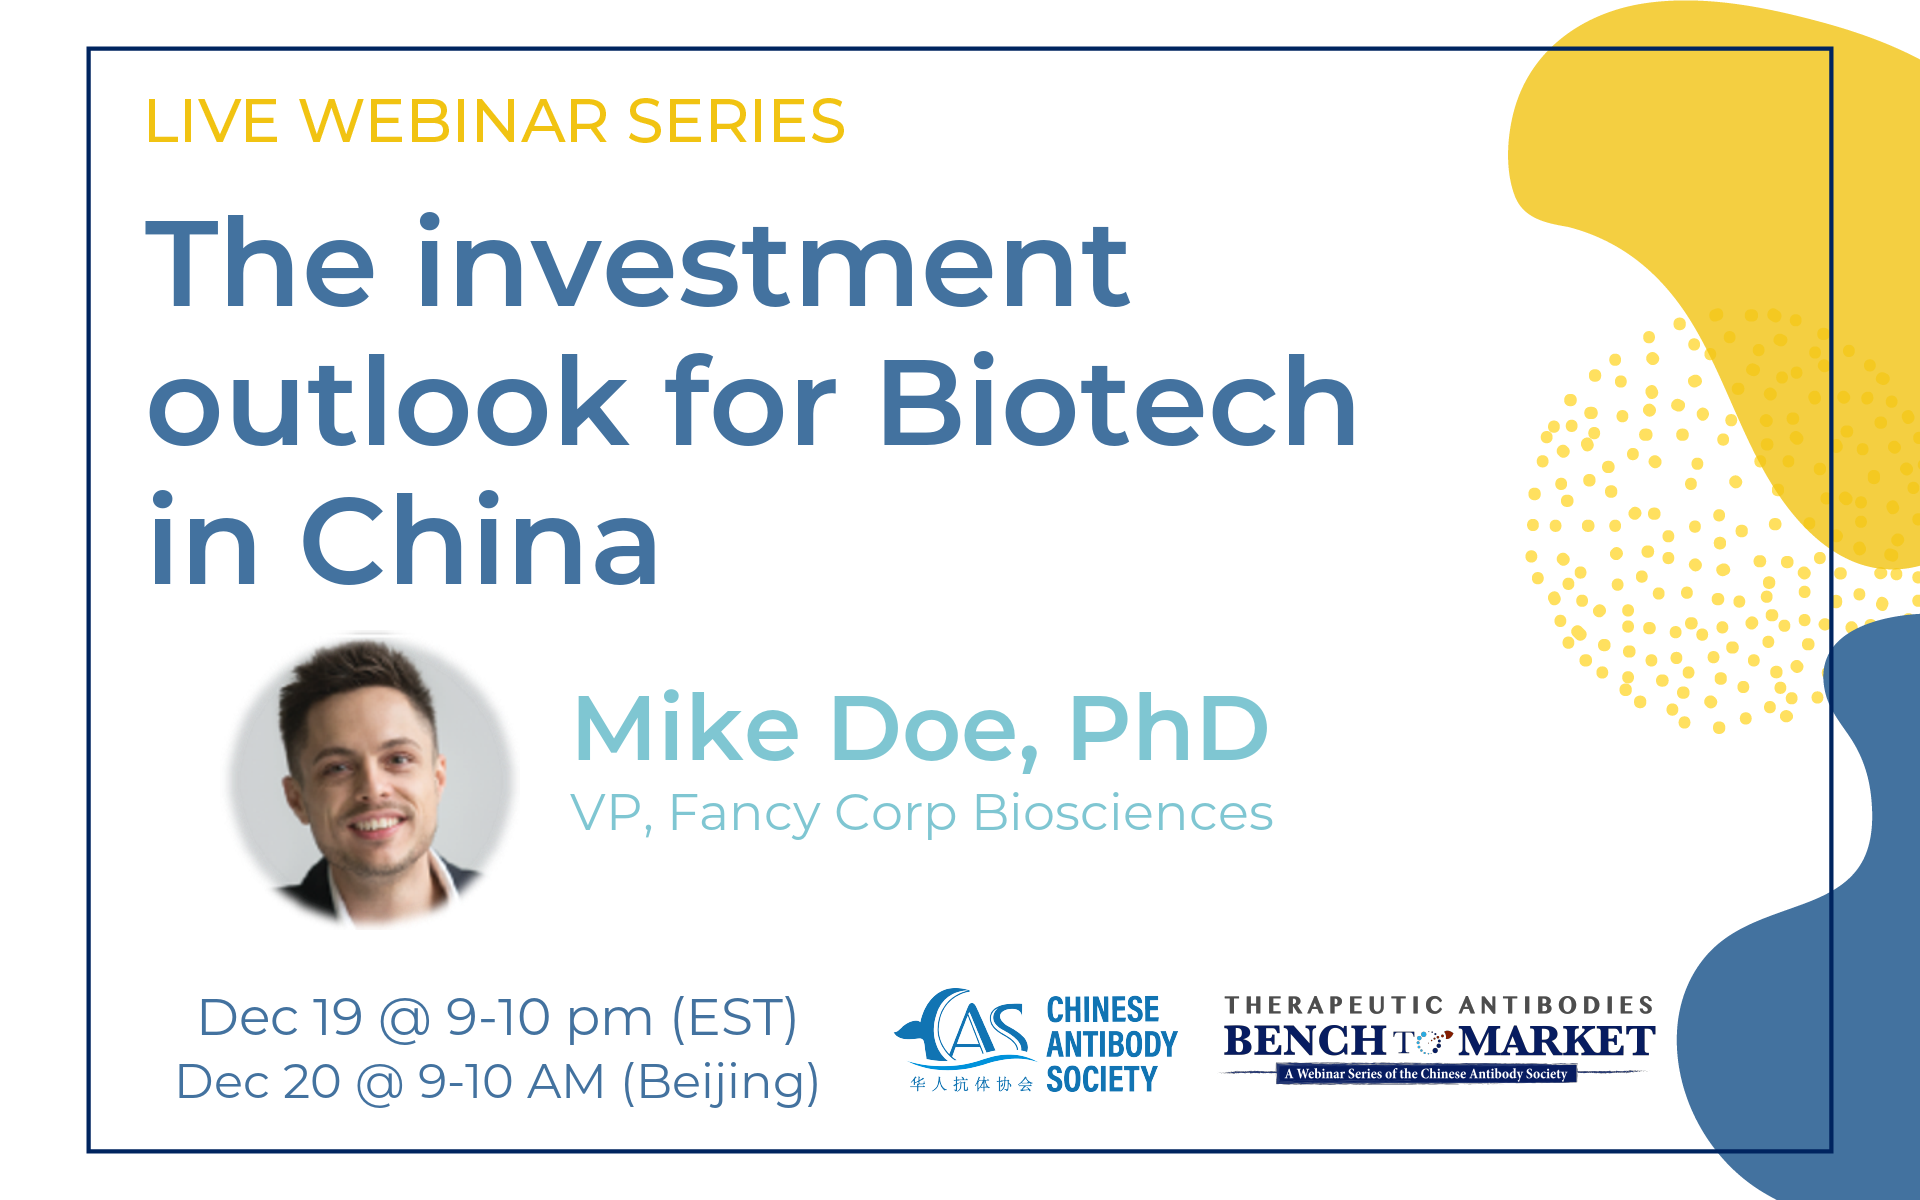

In [8]:
# provide template
template_path = 'template/template-1-clean-01.png'
# provide speaker headshot: here we're using the output png from the `headshot-cropper`
speaker = Image.open('example/example.png').convert('RGBA').resize([300, 300])
# load data
df = pd.read_excel('example/example.xlsx', sheet_name='example')

# create image objects
image = Image.open(template_path)
draw=ImageDraw.Draw(image)

# extract info from pdf and write
title = df.loc[0, 'title']
name = df.loc[0, 'name']
company = df.loc[0, 'company']
date1 = df.loc[0, 'date1']
date2= df.loc[0, 'date2']

# write title
writeMultiline(
    draw, title,
)

# speaker name. adjust max_w to "resize"
writeSingleLine(
    draw, name, box =[570, 670], max_w=700, align = 'left', font_style='fonts/Montserrat-SemiBold.otf', color='#7fc6d2'
)

# speaker position & company. adjust max_w to "resize"
writeSingleLine(
    draw, company, box=[570, 780], max_w = 700, align = 'left', font_style='fonts/Montserrat-Regular.otf', color='#7fc6d2'
)

# date1 adjust max_w to "resize"
writeSingleLine(
    draw, date1, box=[166, 1000, 830, 1030], max_w=600, align='center', font_style='fonts/Montserrat-Regular.otf', color='#43729F'
)

#date2 adjust max_w to "resize"
writeSingleLine(
    draw, date2, box=[166, 1040, 830, 1120], max_w=640, align='center', font_style='fonts/Montserrat-Regular.otf',color='#43729F'
)

# paste speaker headshot
image.paste(speaker, (220, 630), speaker) # pass it twice

# save image
image.save('result/result.png')
image
